<a href="https://colab.research.google.com/github/kalngyk/kalngyk.github.io/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding pairwise dissimilarity from Siamese Network
In this session we shall compare the faces of 18 persons. The face of each person is represented using a few photos (*mugshots*) of the person. 

A neural network is used to compute a **dissimilarity score** between the faces of every two persons through their photos. 

Finally, the dissimilarity scores are stored in a matrix, and used to construct a graph.

This script can be run in Colaboratory (https://colab.research.google.com/), or similar cloud services such as KESCI (https://www.kesci.com/), or on your own PC (rinning Jupyter notebook). However, you will need a GPU to make it run reasonably fast.

*(Neural network codes herein are modified from "https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch")*

---





## Imports

In [2]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
import urllib
import random
import math
import copy
import os
import shutil
import sys

## Helper functions

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (20,3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Data preparation
You are to train data from a file called "data.zip". <br>
**For your first lab session, a ["data.zip" file](https://kalngyk.github.io/data.zip) has been prepared. Simply run this section and it will be automatically used.** In future sessions, you are to upload your own data.zip to Colab. Or if you use your own PC, place data.zip in where this ipynb recides. Here's how you should prepare the file.<br>
To prepare the file, obtain images (in jpg or png format) of several different classes. Each class of images should be of the same subject (e.g. a person's face, a car model). Images in the same class should be visually similar.<br>
About 5$\sim$10 images should be sufficient for each class, but each class must have the same number of images. You should have around 10~100 classes to generate a reasonably nice graph/network. <br>
Put your images for each class in a folder, and put all the folders in a folder called "data". Finally, compress the "data" folder into a zip archive called "data.zip".
See the provided ["data.zip" file](https://kalngyk.github.io/data.zip) for reference.

*If you have fewer images for a certain class, you can duplicate the existing images of that class to make up the number.*

*If you see the error "<U>Upload widget is only available when the cell has been executed in the current browser session</U>", access the URL `chrome://settings/content/cookies` and disable "Block third-party cookies".*



In [4]:
file = urllib.request.urlretrieve('https://kalngyk.github.io/data.zip', 'data.zip')

In [5]:
!ls

data.zip  sample_data


In [6]:
# Unzip data archive

if os.path.exists("data"):
    shutil.rmtree("data")
zip_ref = zipfile.ZipFile("data.zip", 'r')
zip_ref.extractall()
zip_ref.close()
classes = os.listdir("data")
print(len(classes), "classes found: ", end='')
for c in sorted(classes):
    print(c, end=' ')

18 classes found: s1 s10 s11 s14 s18 s21 s25 s26 s27 s28 s29 s30 s31 s34 s37 s40 s41 s8 

## Configuration

In [7]:
class Config():
    training_dir = "./data/"
    train_batch_size = 64
    train_number_epochs = 25

## Custom Dataset Class
A Dataset class supplies data into the SiameseNetwork. This dataset exhaustively enumerates all possible image pairs.

In [9]:
class PairwiseDataset(Dataset):

    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
        self.transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
    # If there are n classes in list, each of m images, then
    # Total number of images = n*m
    # Total number of pairs = (n*m)^2
    # Then i-th element should return element (i/nm, i%nm)
    # Note that both (i, j) and (j, i) will be included, although they are actually the same pair.
    def __getitem__(self, index):
        imgs = self.imageFolderDataset.imgs
        m = len([x for x in imgs if x[1] == 0])
        nm = len(imgs)
        n = int(nm/m)
        img0index = math.floor(index / nm)
        img1index = index % nm
        img0 = Image.open(imgs[img0index][0])
        img1 = Image.open(imgs[img1index][0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        same = np.array([int(imgs[img0index][1]!=imgs[img1index][1])], dtype=np.float32)
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(same)
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)*len(self.imageFolderDataset.imgs)

      
# For creating slides
class _PairwiseDataset(Dataset):

    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
        self.transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
    def __getitem__(self, index):
        c0 = 2
        c1 = 3
        imgs = self.imageFolderDataset.imgs
        imgs0 = [x for x in imgs if x[1] == c0]
        imgs0 = imgs0[:3]
        imgs1 = [x for x in imgs if x[1] == c1]
        imgs1 = imgs1[:3]
        m = len(imgs0)
        nm = len(imgs0)*len(imgs1)
        n = int(nm/m)
        img0index = math.floor(index / m)
        img1index = index % m
        img0 = Image.open(imgs0[img0index][0])
        img1 = Image.open(imgs1[img1index][0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        same = np.array([int(imgs0[img0index][1]!=imgs1[img1index][1])], dtype=np.float32)
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(same)
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)*len(self.imageFolderDataset.imgs)



class RandomSampleDataset(Dataset):
    
    def __init__(self,imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
        self.transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Load input images into Dataset
At each stage each class is assigned a number, which will be used as the class' index in the dissimilarity matrix. <br>
To get the class name back from the index, we store the class names in *Config.labels*. <br>
*Config.labels[i]* will give us the class name for the index *i*.

In [10]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = PairwiseDataset(imageFolderDataset=folder_dataset)
idx2label = {y: os.path.basename(os.path.dirname(x)) for (x, y) in folder_dataset.imgs}
labels = [idx2label[key] for key in sorted(idx2label.keys())]
print(labels)
print("Loaded images of", len(labels), "classes into Dataset. Class names are now stored in Config.labels")

['s1', 's10', 's11', 's14', 's18', 's21', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's34', 's37', 's40', 's41', 's8']
Loaded images of 18 classes into Dataset. Class names are now stored in Config.labels


## Examine data
Randomly get a few pairs of images from the Dataset to see if they are what you uploaded.<br>
The top row and the bottom row of any column is one pair. <br>
For each pair,
1 = different class, 0 = same class. (The majority of the pairs will be of type 1.)

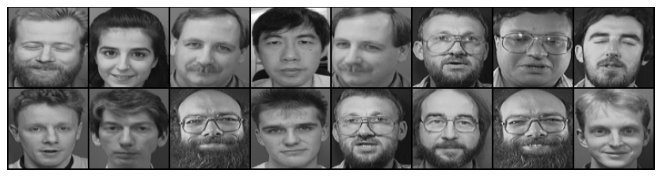

  ['     1', '     1', '     1', '     1', '     1', '     1', '     1', '     1']
  1 means the pair of images belong to two different persons, 0 means otherwise.
  0 is rare to come by. Try rerun this a few times until you get to see a 0.


In [17]:
vis_dataloader = DataLoader(siamese_dataset,shuffle=True,batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

print(" ", ["     " + str(int(d)) for d in example_batch[2].numpy()])
print("  1 means the pair of images belong to two different persons, 0 means otherwise.")
print("  0 is rare to come by. Try rerun this a few times until you get to see a 0.")

## Give access to Google Drive (or your own choice of storage) for saving your trained model 

Colab runs for only 12 hours per-session. That means if your neural network model takes more than 12 hours to train, you will be cut off from your session before you finish training it. 

When your session ends, you will lose all your data, including your model, which has already been trained for 12 hours!

To overcome this, save a copy of your trained model every once in a while during its training in a cloud storage (e.g. Google Drive). That way, after your 12 hour session ends, you can start a new session, retreive that trained model, and continue training that model. By repeating this, you can train a model for as long as you want, and not limited to 12 hours.

Of course, you don't have to bother with this if you are not using colab.

If you use Google Drive, your files will be saved in http://drive.google.com, under the directory "**colab**".

*You can trying downloading the model from colab to your harddisk (using google.colab.files.download), but that doesn't work very well for large file -- and model files are pretty large.*

In [12]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/colab/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))

# Saves the labels for future use 
np.savetxt(savedir + 'labels.txt', labels, delimiter=" ", fmt="%s")
print("Content of {}:".format(savedir))
os.listdir(savedir)

Mounted at /content/gdrive
Content of /content/gdrive/My Drive/colab/:


['labels.txt']

## Define the SiameseNetwork

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Train the neural network

 Epoch 0 Batch 0/506: loss = 3.2815661430358887
 Epoch 0 Batch 253/506: loss = 0.7194260954856873
 Epoch 0 Batch 506/506: loss = 0.07818809151649475
 Epoch 1 Batch 0/506: loss = 0.6169592142105103
 Epoch 1 Batch 253/506: loss = 0.17155422270298004
 Epoch 1 Batch 506/506: loss = 0.7650831937789917
 Epoch 2 Batch 0/506: loss = 0.44660598039627075
 Epoch 2 Batch 253/506: loss = 0.6335954070091248
 Epoch 2 Batch 506/506: loss = 0.9810510277748108
 Epoch 3 Batch 0/506: loss = 0.241620734333992
 Epoch 3 Batch 253/506: loss = 0.29732605814933777
 Epoch 3 Batch 506/506: loss = 0.4226285219192505
 Epoch 4 Batch 0/506: loss = 0.21861103177070618
 Epoch 4 Batch 253/506: loss = 0.4262292981147766
 Epoch 4 Batch 506/506: loss = 0.059286173433065414
 Epoch 5 Batch 0/506: loss = 0.14464953541755676
 Epoch 5 Batch 253/506: loss = 0.42176327109336853
 Epoch 5 Batch 506/506: loss = 0.16619038581848145
 Epoch 6 Batch 0/506: loss = 0.3713991343975067
 Epoch 6 Batch 253/506: loss = 0.4156646430492401
 Epoc

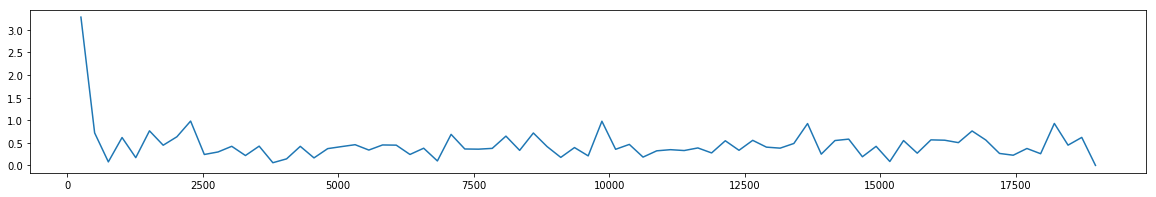

min loss at epoch 24
models saved in drive: ['siamese.0.pth', 'siamese.1.pth', 'siamese.24.pth', 'siamese.4.pth']


In [ ]:
# Model and hyperparameters
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=Config.train_batch_size)
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# If you have a trained network, this is where you load that model to continue training from it.
# Change the filename "siamese.pth" below to your pre-trained model.
continue_from_previous = False
if continue_from_previous:
    net = SiameseNetwork().to(device)
    net.load_state_dict(torch.load(savedir + 'siamese.1.pth'))

counter = []
loss_history = []
interval_num = 0
batches_per_epoch = int(len(siamese_dataset) / Config.train_batch_size)
total_batches = batches_per_epoch * Config.train_number_epochs
num_intervals = 50
num_batches_per_interval = int(total_batches / num_intervals)
min_loss_epoch = 0
min_loss = 100

for epoch in range(0, Config.train_number_epochs):
    for batch, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if batch % num_batches_per_interval == 0:
            print(" Epoch {} Batch {}/{}: loss = {}".format(epoch, batch, batches_per_epoch, loss_contrastive.item()))
            interval_num += num_batches_per_interval
            counter.append(interval_num)
            loss_history.append(loss_contrastive.item())
    # Save the trained SiameseNetwork if it is better than the current best
    if loss_contrastive.item() < min_loss:
        min_loss = loss_contrastive.item()
        min_loss_epoch = epoch
        model_filename = savedir + "siamese." + str(epoch) + ".pth"
        trained_model = copy.deepcopy(net.state_dict())
        torch.save(trained_model, model_filename)

plt.plot(counter, loss_history)
plt.show()

# Save the trained SiameseNetwork at the end of the training 
model_filename = savedir + "siamese." + str(epoch) + ".pth"
trained_model = copy.deepcopy(net.state_dict())
torch.save(trained_model, model_filename)
print("min loss at epoch", min_loss_epoch)
print("models saved in drive:", [f for f in os.listdir(savedir) if f.endswith('pth')])

## Compute pairwise dissimilarities of all images using the trained neural network
Compute the dissimilarities between pairwise images in the training set. The dissimilarity between two persons is then calculated as the sum of the dissimilaries between their mugshots. 
Finally, the dissimilarities between every pair of persons are stored in dissimilarity matrix.

In [ ]:
# Load a saved copy of the trained SiameseNetwork
net = SiameseNetwork().to(device)
_ = net.load_state_dict(torch.load(savedir + 'siamese.24.pth'))

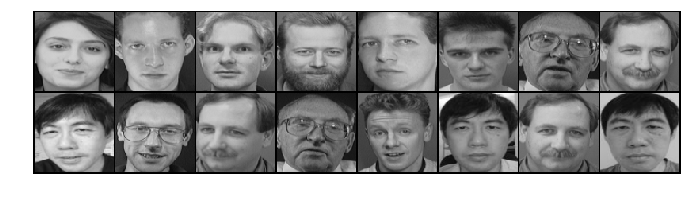

['   3.89', '   2.74', '   1.84', '   4.24', '   3.04', '   2.91', '   2.03', '   3.44']


In [ ]:
# Check the performance of the trained network

vis_dataloader = DataLoader(siamese_dataset,shuffle=True,batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]), 0)
distance = []
for i in range(8):
    x0 = example_batch[0][i]
    x1 = example_batch[1][i]
    output1, output2 = net(x0[None, :, :].to(device), x1[None, :, :].to(device))
    distance.append(F.pairwise_distance(output1, output2).cpu().detach().numpy())
distance = ["   " + str(round(item, 2)) for sublist in distance for item in sublist]

imshow(torchvision.utils.make_grid(concatenated))
print(distance)

In [ ]:
# Find pairwise matrix of dissimilarity between classes in training_set
folder = dset.ImageFolder(root=Config.training_dir)
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

img_per_class = len([x for x in folder.imgs if x[1] == 0])
nclasses = int(len(folder.imgs)/img_per_class)
sim = np.zeros((nclasses, nclasses))

for t0 in folder.imgs:
    for t1 in folder.imgs:
        c0 = t0[1]
        c1 = t1[1]
        x0 = Image.open(t0[0])
        x1 = Image.open(t1[0])
        x0 = transform(x0.convert("L"))
        x1 = transform(x1.convert("L"))
        img0 = x0[None, :, :].to(device)
        img1 = x1[None, :, :].to(device)
        output1, output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        sim[c0,c1] += euclidean_distance.cpu().detach().numpy()
        
np.savetxt(savedir + 'sim.txt', sim)
print("Generated %dx%d matrix in file \"%s\"" % (sim.shape[0], sim.shape[1], savedir + 'sim.txt'))

Generated 18x18 matrix in file "/content/gdrive/My Drive/colab/sim.txt"


## Build graph/network
Build graph/network from the dissimilarity matrix.<br>
A more elaborated version of this is in the next session: "**Community Detection**", where we will use the module NetworkX to visualize and analyze the network.

In [ ]:
sim = np.loadtxt(savedir + 'sim.txt')
labels = list(np.genfromtxt(savedir + 'labels.txt', dtype='str'))

print("Restored %dx%d matrix" % (sim.shape[0], sim.shape[1]))
print("Labels of elements:", labels)

Restored 18x18 matrix
Labels of elements: ['s1', 's10', 's11', 's14', 's18', 's21', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's34', 's37', 's40', 's41', 's8']


diagonal avg=151.06 min=89.76 max=198.09


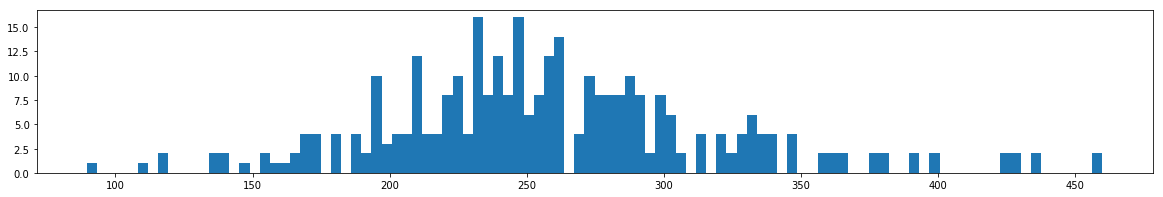

In [ ]:
# Analyze distribution of dissimilarity score

d = np.diagonal(sim)
print('diagonal avg=%.2f min=%.2f max=%.2f' % (np.mean(d), np.min(d), np.max(d)))
simflat = sim.reshape((-1,))
_ = plt.hist(simflat, bins=100)

In [ ]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 200
adjmat = sim.reshape((-1,)).copy()
adjmat[adjmat > threshold] = 0
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)

278 out of 324 values set to zero


##Output edges for visualization in Gephi

Gephi Download - https://gephi.org/users/download/<br>
Gephi HOWTO    - https://gephi.wordpress.com/2017/09/26/gephi-0-9-2-a-new-csv-importer/


In [ ]:
# Generate edges for Gephi

def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(savedir + filename, 'w')
    if header:
        f.write("Source,Target\n")
    loc = np.where(sim > 0)
    for (i, j) in [(i, j) for (i, j) in zip(loc[0], loc[1]) if i < j]:
        if labels == None:
            f.write(str(i) + delim + str(j) + "\n")
        else:
            f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

export_edge_list(adjmat, labels=labels, filename='gephi-edges.csv')

os.listdir(savedir)

['dissim.tsv',
 'labels.txt',
 'siamese.0.pth',
 'siamese.1.pth',
 'gephi-edges.csv',
 'pals-edges.txt',
 'pals-community.txt',
 'siamese.24.pth',
 'sim.txt']